# Group 1 Capstone Project Work
### Make sure to make / checkout your own branch before making changes

# Maddie Hince

In [10]:
import pandas as pd
import sqlite3

df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
df.head()


conn = sqlite3.connect('zippedData/im.db.zip')
pd.read_sql("""SELECT *""")

DatabaseError: Execution failed on sql '
SELECT *
FROM im
': file is not a database

# Cat Murad

# Elijah Soba

In [1]:
# Import statements
import sqlite3 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

In [2]:
# Define filepath & read in the data 
filepath = 'zippedData/bom.movie_gross.csv.gz'
movie_gross_df = pd.read_csv(filepath)

In [3]:
# Take a prelimary look at the data
movie_gross_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [4]:
# Take a look at the data frame information
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


From looking at the information we can see immediately that there are a couple things wrong with the data:
- There are missing values in studio, domestic gross, and foreign gross
- Foreign gross is represented as an object instead of a float
- Year is represented as an integer, but it is probably better to have it as a datetime object

## Cleaning Step 1: Change Dtypes

We want to be sure that all of the dtypes that we are working with are acurately represented by the correct python type that we expect. Looking at the data frame information, we see that `foreign_gross` is represented as an `object` when we would expect to see it as a `float`. In addition, year is represented as an `int` when we would expect it to be a `datetime` object. We can use Pandas to change this data to meet our data type expectations

In [5]:
# Lets recast foregin_gross as a float 
str_to_float = lambda x: float(str(x).replace(',', ''))
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].map(str_to_float)

In [6]:
# Lets test to see if the data type actually changed 
assert movie_gross_df['foreign_gross'].dtype  == np.float64

In [7]:
# Lets recast year as a datetime object 
movie_gross_df['year'] = pd.to_datetime(movie_gross_df['year'], format='%Y')

In [8]:
# Lets test to see if this worked
assert movie_gross_df['year'].dtype != np.int64

## Cleaning Step 2: Handle Missing Data

First, we look at the `studio` column because that is the column with the least amount of missing data. In addition, it is the easiest to deal with because missing values can be replaced with 'IND' standing for independent film 

Next, we look at the `domestic_gross` column which is one of the primary sources of data in this table. We check to see what percentage of the data is corrupted, and if it is small we will simply delete those rows. If it is not, we will explore data imputation techniques

Finally, we look at the `foreign_gross` column and perform the same analysis as the `domestic_gross`. Seeing that it is a big chunk of the data, we will most likely have to impute. Imputation can be done by looking at a summary statistic of the percent change between `foreign_gross` and `domestic_gross` and using that to make up a value for `foreign gross` as a function of `domestic_gross`. 


In [9]:
# Lets replace missing studios with 'IND' representing independent
movie_gross_df['studio'] = movie_gross_df['studio'].fillna('IND')

In [10]:
# Test to see if there are any missing values in the studio column
assert movie_gross_df['studio'].isna().sum() == 0

In [11]:
# Lets see what percentage of the domestic gross data is missing 
pct_missing_dom = movie_gross_df.domestic_gross.isna().sum()/len(movie_gross_df.title)
print(f'Missing domestic gross data represents {pct_missing_dom*100}% of the data')

Missing domestic gross data represents 0.8266902863891349% of the data


In [12]:
# The missing data is a very small fraction, so lets delete those rows
movie_gross_df = movie_gross_df.dropna(axis=0, subset=['domestic_gross'])

In [13]:
# Test to see whether that deletion worked
assert movie_gross_df['domestic_gross'].isna().sum() == 0

In [14]:
# Lets see what percentage of the foreign gross data is missing 
pct_missing_dom = movie_gross_df.foreign_gross.isna().sum()/len(movie_gross_df.title)
print(f'Missing domestic gross data represents {pct_missing_dom*100}% of the data')

Missing domestic gross data represents 40.190532896695444% of the data


In [15]:
# That is too much, so lets find the median pct change between domestic and foreign films
med_pct_change = ((movie_gross_df['foreign_gross'] - movie_gross_df['domestic_gross'])/movie_gross_df['domestic_gross']).median()
print(med_pct_change)

0.6315266036797613


In [16]:
# Now that we have the median % change, lets impute the missing foreign values 
impute_change = movie_gross_df['domestic_gross'] + (movie_gross_df['domestic_gross'] * med_pct_change)
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].fillna(impute_change)

In [17]:
# Test that we now have no more NaN values in the data 
assert movie_gross_df['foreign_gross'].isna().sum() == 0

In [18]:
# Finally, test to see if there are any missing values anywhere in the data 
assert movie_gross_df.isna().sum().sum() == 0

## Data Exploration: 

Now that we do not have any more missing values, we can begin data exploration. Because we want to see what contributes to a successful movie, we can look at how gross changes depending on different factors such as year and studio. In addition, we can explore the relationships within and between these variables to see if any meaningful conclusions can be drawn.

## Step 1: Explore Values in the Gross Columns

In [19]:
# Lets feature engineer a new feature that can be useful to our understanding of gross as a whole
movie_gross_df['total_gross'] = movie_gross_df['foreign_gross'] + movie_gross_df['domestic_gross']

In [20]:
# Test to see whether that column was successfully created 
assert 'total_gross' in movie_gross_df.columns

In [21]:
# Lets take a look at that newly created column 
movie_gross_df['total_gross'].sort_values()

1476    2.631527e+02
2757    7.894580e+02
2756    7.894580e+02
2321    7.894580e+02
3078    1.052611e+03
            ...     
2758    1.332600e+09
328     1.341500e+09
3080    1.347000e+09
1875    1.405400e+09
727     1.518900e+09
Name: total_gross, Length: 3359, dtype: float64

In [22]:
# Lets normalize the data to millions to make numbers more manageable
movie_gross_df['total_gross'] = movie_gross_df['total_gross']/1000000
movie_gross_df['domestic_gross'] = movie_gross_df['domestic_gross']/1000000
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross']/1000000

In [23]:
# Lets take another look 
movie_gross_df['total_gross'].sort_values()

1476       0.000263
2757       0.000789
2756       0.000789
2321       0.000789
3078       0.001053
           ...     
2758    1332.600000
328     1341.500000
3080    1347.000000
1875    1405.400000
727     1518.900000
Name: total_gross, Length: 3359, dtype: float64

In [24]:
# Lets see what movie grossed the most 
movie_gross_df.loc[movie_gross_df['total_gross'].idxmax(), :]

title             Marvel's The Avengers
studio                               BV
domestic_gross                    623.4
foreign_gross                     895.5
year                2012-01-01 00:00:00
total_gross                      1518.9
Name: 727, dtype: object

In [25]:
# Lets see what film did the best in terms of domestic gross 
movie_gross_df.loc[movie_gross_df['domestic_gross'].idxmax(), :]

title             Star Wars: The Force Awakens
studio                                      BV
domestic_gross                           936.7
foreign_gross                        0.0011316
year                       2015-01-01 00:00:00
total_gross                            936.701
Name: 1872, dtype: object

In [26]:
# Lets see what film did the best in terms of foreign gross 
movie_gross_df.loc[movie_gross_df['foreign_gross'].idxmax(), :]

title             Harry Potter and the Deathly Hallows Part 2
studio                                                     WB
domestic_gross                                            381
foreign_gross                                           960.5
year                                      2011-01-01 00:00:00
total_gross                                            1341.5
Name: 328, dtype: object

<AxesSubplot:ylabel='Frequency'>

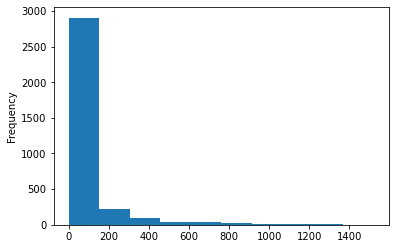

In [27]:
# Lets visualize the distribution of total gross data 
movie_gross_df['total_gross'].plot.hist()

<AxesSubplot:xlabel='domestic_gross', ylabel='foreign_gross'>

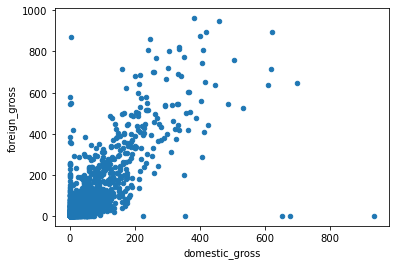

In [28]:
# Lets visually see the correlation between domestic and foreign gross
movie_gross_df.plot.scatter('domestic_gross', 'foreign_gross')

By looking at the scatter plot, we can notice two main things. 
- There is a positive correlation between domestic gross and foreign gross which is expected 
- There are a lot of data points that seemingly have 0 domestic gross and non-zero foreign gross (and vice versa)

In [29]:
# Lets quickly verify that there are no films with 0 domestic gross 
assert movie_gross_df[movie_gross_df['domestic_gross'] == 0.0].sum()[0] == 0

In [30]:
# Lets quickly verify that there are no films with 0 domestic gross 
assert movie_gross_df[movie_gross_df['foreign_gross'] == 0.0].sum()[0] == 0

## Step 2: Looking at the Gross Data over time

In [31]:
# Lets see which years are represented in the data
movie_gross_df['year'].value_counts()

2015-01-01    449
2016-01-01    433
2011-01-01    397
2012-01-01    393
2014-01-01    391
2013-01-01    345
2010-01-01    323
2017-01-01    320
2018-01-01    308
Name: year, dtype: int64

<AxesSubplot:xlabel='year', ylabel='domestic_gross'>

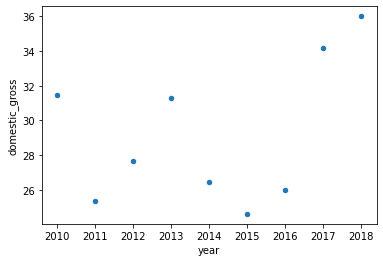

In [32]:
# Lets see how the average domestic gross varied over the years 
movie_gross_df.groupby('year').mean().reset_index().plot.scatter('year', 'domestic_gross')

<AxesSubplot:xlabel='year', ylabel='foreign_gross'>

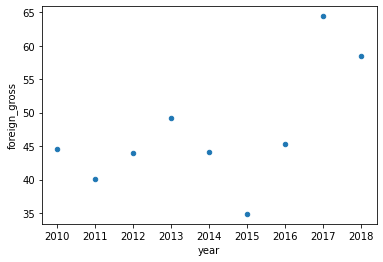

In [33]:
# Lets see how the average foreign gross varied over the years 
movie_gross_df.groupby('year').mean().reset_index().plot.scatter('year', 'foreign_gross')

<AxesSubplot:xlabel='year', ylabel='total_gross'>

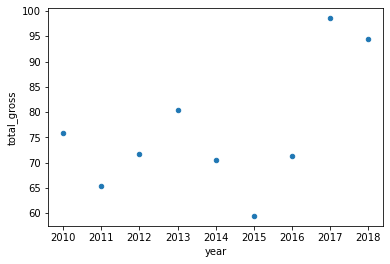

In [34]:
# Lets see how the average total gross varied over the years 
movie_gross_df.groupby('year').mean().reset_index().plot.scatter('year', 'total_gross')

## Step 3: How Well Did Specific Studios Do?

In [35]:
# Lets inspect all of the studios to see if there is any duplicates w/misspellings
movie_gross_df['studio'].value_counts().sort_values(ascending=False)

IFC      166
Uni.     147
WB       140
Fox      136
Magn.    136
        ... 
PBS        1
PDF        1
CP         1
AaF        1
Truly      1
Name: studio, Length: 256, dtype: int64

<AxesSubplot:xlabel='studio'>

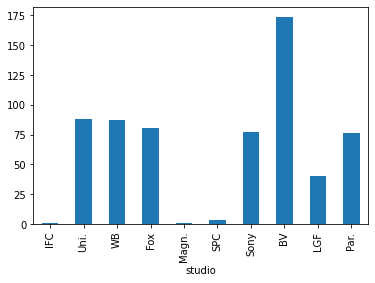

In [36]:
# Lets see how the top 10 most producing studios did in terms of average total gross
top10_prod = list(movie_gross_df['studio'].value_counts().sort_values(ascending=False)[:10].index)
movie_gross_df.groupby('studio').mean()['domestic_gross'].loc[top10_prod].plot.bar()

<AxesSubplot:xlabel='studio'>

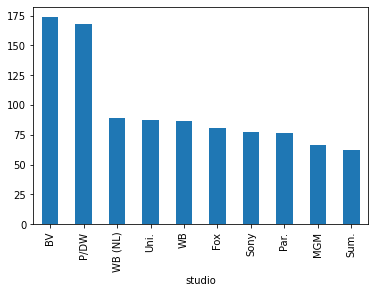

In [37]:
# Instead, lets use the top 10 highest earners
movie_gross_df.groupby('studio').mean()['domestic_gross'].sort_values(ascending=False)[:10].plot.bar()

# Luis Estrada 

# Kilmar Lazo 

# Michael Eugene